# Ensayo de Tensión
Curvas de Esfuerzo Vs Deformación

In [210]:
# LIBRERÍAS
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression 
import numpy as np
from scipy import signal as sp
import sympy as sym
# variables simbolicas e: deformacion y s: esfuerzo,
from sympy.abc import e, s

Se importan datos tomados de la máquina Universal de Ensayos para una prueba de tensión en una probeta de acero

In [211]:
# RECOPILACIÓN DE DATOS
tabla1 = pd.read_excel('1NA.xlsx')

# GEOMETRÍA DE LA PROBETA
longitud_inicial = 25; #Longitud inicial del especímen mm
area = 6.48*6.03 #área de la sección transversal en mm

# DATOS
Carga = tabla1.FORCE #Fuerza aplicada en N
Alargamiento = tabla1.POSIT #alargamiento del especímen
Deformacion = Alargamiento/longitud_inicial

c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Características del material

In [212]:
Esfuerzo = Carga/area
max_esf = np.amax(Esfuerzo) # Esfuerzo último
S_f = Esfuerzo[len(Esfuerzo)-1] # Esfuerzo a la fractura
F_f = S_f*area # Fuerza de fractura
e_f = Alargamiento[len(Alargamiento)-1] # Alargamiento a la fractura

<h5> DELIMITACIÓN DE LA ZONA ELÁSTICA </h5>
Límite elástico y resistencia a la fluencia


In [213]:
LE = Esfuerzo/Deformacion # taza de cambio del esfuerzo por unidad de deformación
for i in Esfuerzo:
  pos = np.where(Esfuerzo == i)[0][0] #i es el valor del esfuerzo
  if pos < len(Esfuerzo)-1:
    index = pos 
    #si la sensibilidad del módulo de young es cercana al 5%
   # print(LE[index+1]/LE[index])
    if LE[index+1]/LE[index]<1 and LE[index+1]/LE[index]>0.999:
       limit = np.where(Esfuerzo==i)[0][0]
          
sigma = [] #asignación de los datos de esfuerzo a un array
for i in Esfuerzo:
  if np.where(Esfuerzo == i)[0][0] < limit:
    sigma.append(i)

Resistencia a la fluencia

In [214]:
Sy_Sigma = np.amax(sigma)
sd_e = Deformacion[np.where(Esfuerzo==Sy_Sigma)[0][0]]

MÓDULO DE YOUNG / Límite elástico

In [215]:
Sigma = []
Epsilon = []
delta_l = []
for i in Esfuerzo:
  if np.where(Esfuerzo == i)[0][0] < np.where(Esfuerzo == Sy_Sigma)[0][0]:
    if i > 200 and i < 300:
      index = np.where(Esfuerzo==i)[0][0]
      Sigma.append(i)
      epsilon = Deformacion[index]
      Epsilon.append(epsilon)
      delta_l.append(epsilon*longitud_inicial)
      
regresion_lineal = LinearRegression() # instancia de LinearRegression
regresion_lineal.fit(np.reshape(Epsilon,(-1,1)), Sigma)
E = regresion_lineal.coef_/1000

estimado_sigma = regresion_lineal.predict(np.reshape(Epsilon,(-1,1)))
estimado_carga = estimado_sigma*area
rho = np.corrcoef(Epsilon, estimado_sigma)

print(rho)

[[1. 1.]
 [1. 1.]]


In [216]:
# ELONGACIÓN
epsilon_e = (e_f/longitud_inicial-(S_f/(E*1000)))*100
e = epsilon*longitud_inicial

Visualización de datos

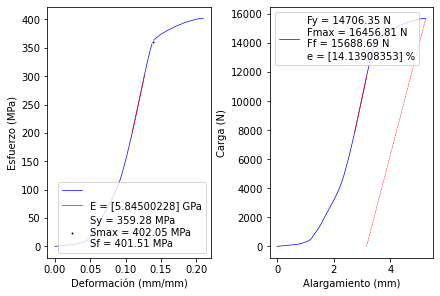

In [231]:
#VISUALIZACIÓN DE DATOS

plt.figure(layout="constrained")
plt.subplot(121)
plt.plot(Deformacion, Esfuerzo, color="blue", linewidth=".7")
plt.plot(Epsilon, estimado_sigma, color="red", linewidth=".7")
plt.plot(sd_e, Sy_Sigma, color="white", marker='o', markerfacecolor='black', markersize=3)
plt.xlabel('Deformación (mm/mm)')
plt.ylabel('Esfuerzo (MPa)')
plt.title(['',
            'E = '+str(E)+' GPa',
            'Sy = '+str(round(Sy_Sigma, 2))+' MPa \n'
            'Smax = '+str(round(max_esf,2))+' MPa \n'
            'Sf = '+str(round(S_f,2))+' MPa']);

plt.subplot(122)
plt.plot(Alargamiento,Carga, color="blue", linewidth=".7")
plt.plot(delta_l, estimado_carga, color="red", linewidth=".7")
plt.plot([e,e_f], [0,F_f], linestyle="--", color="red", linewidth=".5")
plt.xlabel('Alargamiento (mm)')
plt.ylabel('Carga (N)')
plt.title(['Fy = '+str(round(Sy_Sigma*area, 2))+' N \n'
            'Fmax = '+str(round(max_esf*area,2))+' N \n'
            'Ff = '+str(round(F_f,2))+' N \n'
            'e = '+str(epsilon_e)+' %']);

Módulo de tenacidad / Se segmenta la curva esfuerzo/deformación a tramos según aproximación en el punto 0.14 

In [217]:
for i in Esfuerzo:
  index = np.where(Esfuerzo == i)[0][0] #i es el valor del esfuerzo
  #si la sensibilidad del módulo de young es cercana al 5%
  if Deformacion[index]<0.14:
      limit = np.where(Esfuerzo==i)[0][0]

sigma1 = [] #asignación de los datos de esfuerzo a un array1 en el tramo de la deformacion menor a 0.14
def1 = []
sigma2 = [] #asignación de los datos de esfuerzo a un array 2 para el siguiente tramo
def2 = []

for i in Esfuerzo:
  if np.where(Esfuerzo == i)[0][0] <= limit: # Tramo 1
    sigma1.append(i)
    def1.append(Deformacion[np.where(Esfuerzo == i)[0][0]])
  if np.where(Esfuerzo == i)[0][0] > limit: # Tramo 2
    sigma2.append(i)
    def2.append(Deformacion[np.where(Esfuerzo == i)[0][0]])


<h5>Aproximación mediante polinomios de Lagrange a tramos</h5>
Tramo 1

In [218]:
n = len(def1) # Número de elementos en el tramo 1
x = sym.Symbol('x') 
polinomio1 = 2 # Punto inicial del polinomio
for i in range(0,n,50):
    # Primer termino de la Langrage
    numerador = 1
    denominador = 1
    # Recorrido del numerador por todos los puntos del vector x
    for j in range(0,n,50):
        if (i != j):
            numerador = numerador*(x-def1[j])
            denominador = denominador*(def1[i]-def1[j])
        # Calculo de términos de Lagrange
        termino = (numerador/denominador)*sigma1[i]
    # Acumulación de términos
    polinomio1 += termino

# Forma lamda del polinomio px, referencia x y el polinomio que se desea convertir
px1 = sym.lambdify(x, polinomio1)
print(polinomio1)

1000276.60003851*x*(x - 0.128016004562378)*(x - 0.10873740196228) - 3791330.47327396*x*(x - 0.128016004562378)*(x - 0.0840231990814209) + 2839749.79062229*x*(x - 0.10873740196228)*(x - 0.0840231990814209) - 29.0333795499749*(x - 0.128016004562378)*(x - 0.10873740196228)*(x - 0.0840231990814209) + 2


Tramo 2

In [219]:
n = len(def2) # Número de elementos en el tramo 2
y = sym.Symbol('y') 
polinomio2 = 0 # Punto inicial del polinomio
for i in range(0,n,10):
    numerador = 1
    denominador = 1
    # Recorrido del numerador por todos los puntos del vector y
    for j in range(0,n,10):
        if (i != j):
            numerador = numerador*(y-def2[j])
            denominador = denominador*(def2[i]-def2[j])
        termino = (numerador/denominador)*sigma2[i]
    polinomio2 += termino

px2 = sym.lambdify(y, polinomio2)
print(polinomio2)

281231.175239847*(y - 0.199618606567383)*(y - 0.161874179840088) - 466231.936672706*(y - 0.199618606567383)*(y - 0.140157203674316) + 178286.262575092*(y - 0.161874179840088)*(y - 0.140157203674316)


Área bajo la curva

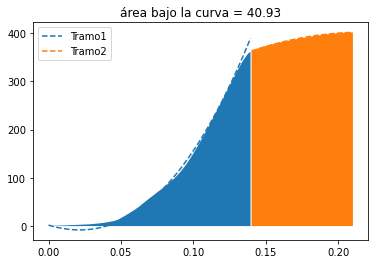

In [220]:
# Vectores para graficas
muestras = 100 # Numero cualquiera
a = np.min(def1)
b = np.max(def1)
p_xi1 = np.linspace(a,b,muestras)
pfi1 = px1(p_xi1)

# Integral definida en el tramo 1 de a - b
area1 = sym.integrate(polinomio1, (x, a, b))

c = np.min(def2)
d = np.max(def2)
p_xi2 = np.linspace(c,d,muestras)
pfi2 = px2(p_xi2)

# Integral definida en el tramo 1 de c - d
area2 = sym.integrate(polinomio2, (y, c, d))

area = area1 + area2

# Grafica
plt.fill_between(def1,sigma1)
plt.fill_between(def2,sigma2)
plt.plot(p_xi1,pfi1, '--', label='Tramo1')
plt.plot(p_xi2,pfi2, '--', label='Tramo2')
plt.title('área bajo la curva = '+str(round(area,2)))
plt.legend()
plt.show()